# Assignment 1 2AMM10 2023-2024

## Group: 8
### Member 1: Lazaros Adaloglou
### Member 2: Milena Galabinova
### Member 3: Nicolás Martínez Van der Looven

Imports.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle

Function for loading data.

In [2]:
# function for loading the training data:
def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

Depending on which environment you are running the notebook, load the data files in the specified way:

- On Google Collab, add data files to your google drive under the following path: \
"/MyDrive/Projects/Deep Learning/Assignment 1/".

- On Kaggle, upload the data files directly as a new dataset in the input tab with the following name: \
"dl-assingment1-data"

- On a local machine, add the data files to the directory were you are running the notebook.

In [3]:
import os

print('Importing training data from file...')

train_path = 'train_data.pkl'
l = 0

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    print('Importing file from GDrive')

    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Projects/Deep Learning/Assignment 1/')
    train_path = 'Data/train_data.pkl'
else:
    try:
        os.chdir('/kaggle/')
        try:
            train_path = 'input/dl-assignment1-data/train_data.pkl'
            train_data = load_data(train_path)
            print("Running on Kaggle")
            l = 1
        except:
            train_path = 'input/dl-a1-data/train_data.pkl'
            train_data = load_data(train_path)
            print("Running on Kaggle")
            l = 1
    except:
        print("Not running on CoLab/Kaggle")

if l == 0:
    train_data = load_data(train_path)

Importing training data from file...
Running on Kaggle


Print the number of available images in the training set.

In [4]:
s=0
for alph, chars in train_data.items():
    for char, imgs in chars.items():
        s += len(imgs)
print(s)

19280


Example demonstrating the training data structure.

In [5]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.
# see the code below for examples of working with the train data
alphabets = list(train_data.keys())

print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


Visualizing some training data.

In [6]:
# function for plotting some examples:
def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


Plot the images.

<Figure size 640x480 with 0 Axes>

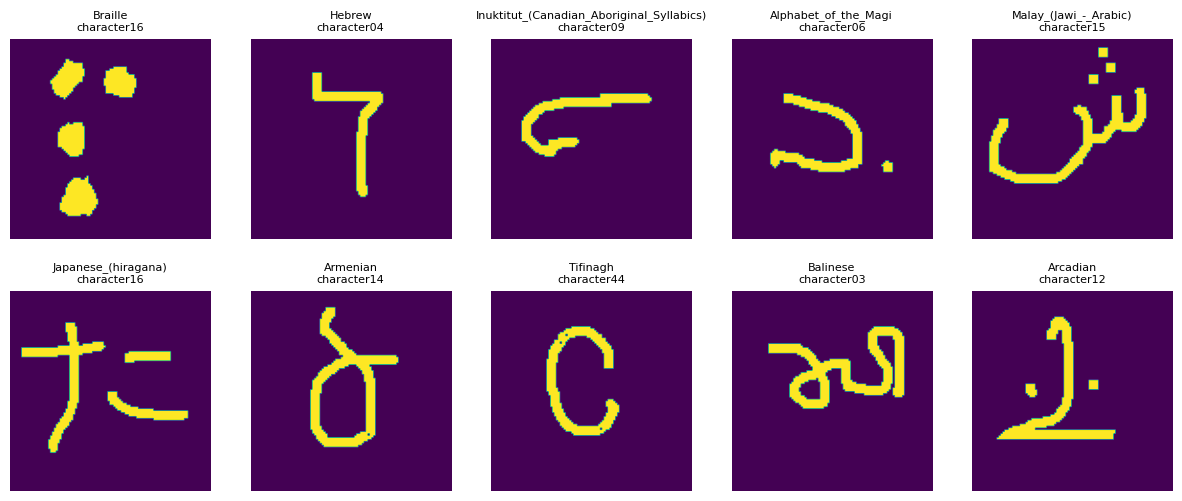

In [7]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [8]:
# our solution: In order to make character recognition feasible for the given task, we will implement a Prototypical Convolutional Neural Network for
# Few-shot Learning. For reference we got inspired by the following paper https://arxiv.org/abs/1703.05175.

# To implement this model, we made use of a relatively simple CNN with 4 convolutional blocks, each with 64 filter 3x3 2D convolutional layer,
# batch normalization, non-linear ReLU function and 2x2 maxpooling. This is used to make 128-dimensional embeddings of the given images.

# We implement a custom batch sampler to sample 'n_way' characters from all alphabets and 'n_shots'+'n_query' images for each character. For each character:
# We compute 'n_shots' support vectors using the CNN, and these are used to compute the 128-dimensional representation (prototype) of the given characters.
# Then, given a distance, the model's output is a distribution over the character classes by computing the softmax over distances to the prototypes in the
# embedding space. These is used to compute a loss function, in particular the negative log probability. We can from this distribution obtain a set of k suggested
# character labels for a given image.

# For evaluating the model, again we will be using a set of support vectors and query vectors. The k-accuracy is defined as the percentage of images
# whose true character label is in the k suggested set of labels.

Imports.

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Convert data to AlphabetDataset. Constructs a Dataset from a dictionary of alphabets with their respective characters and a list of example images (in the form of tensors) for each character.

In [10]:
class AlphabetDataset(Dataset):
    """
    AlphabetDataset.
    Constructs a Dataset from a dictionary of alphabets with their respective characters and a list of example images (in the form
    of tensors) for each character.
    """
    def __init__(self, data_path, transform=None):
        """
        Construct the dataset. Additionally, construct lists of character labels and alphabets.
        Args:
        - data_path: path to the dictionary containing the form {alphabet: {character: list[images]}}.
        - transform: Optional transform to be applied on a sample.
        """
        self.alphabet_dict = load_data(data_path)
        self.transform = transform
        # Fill the class' data, labels, character and alphabet lists by reading the dictionary.
        self.data = []
        self.labels = []
        self.characters = []
        self.alphabets = list(self.alphabet_dict.keys())
        label_idx = 0
        for alphabet in self.alphabets:
            characters = self.alphabet_dict[alphabet].keys()
            for character in characters:
                images = self.alphabet_dict[alphabet][character]
                if self.transform:
                    for image in images:
                        image = self.transform(image)
                        image = image.unsqueeze(0)
                        self.data.extend(image)
                else:
                    self.data.extend(images)
                self.labels.extend([label_idx] * len(images))
                self.characters.extend([alphabet + "-" + character] * len(images))
                label_idx += 1

    # Methods required in a Dataset Subclass.
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

    # Some more get methods.
    def getalphabet(self, idx=None):
        if idx is not None:
            return self.characters[idx].split("-")[0]
        return self.alphabets

    def getcharacter(self, idx=None):
        if idx is not None:
            return self.characters[idx]
        return self.characters

Impementation of the Prototypical Network.

In [11]:
class EmbeddingNet(nn.Module):
    """
    A Convolutional Neural Network (CNN) for embedding images into a lower-dimensional feature space.

    This network is designed to extract features from input images using several convolutional layers
    followed by fully connected layers to produce a fixed-size embedding vector.
    """
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        # Convolutional blocks with Conv2d, BatchNorm2d, ReLU activation, and MaxPool2d layers
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # 1 input channel (grayscale), 64 output channels, 3x3 kernel, padding=1
            nn.BatchNorm2d(64),              # Batch normalization layer for 64 channels
            nn.ReLU(),                       # ReLU activation function
            nn.MaxPool2d(2),                 # Max pooling layer with 2x2 window

            nn.Conv2d(64, 128, 3, padding=1),# 64 input channels, 128 output channels, 3x3 kernel, padding=1
            nn.BatchNorm2d(128),             # Batch normalization layer for 128 channels
            nn.ReLU(),                       # ReLU activation function
            nn.MaxPool2d(2),                 # Max pooling layer with 2x2 window

            nn.Conv2d(128, 256, 3, padding=1),# 128 input channels, 256 output channels, 3x3 kernel, padding=1
            nn.BatchNorm2d(256),             # Batch normalization layer for 256 channels
            nn.ReLU(),                       # ReLU activation function
            nn.MaxPool2d(2)                  # Max pooling layer with 2x2 window
        )

        # Fully connected layers
        self.fully_connected = nn.Sequential(
            nn.Linear(256 * 13 * 13, 256),   # Flattened input size of 256*13*13, output size of 256
            nn.ReLU(),                       # ReLU activation function
            nn.Linear(256, 128)              # Input size of 256, output size of 128 (embedding size)
        )

    def forward(self, x):
        """
        Forward pass of the network.

        Parameters:
        x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        torch.Tensor: Output tensor of shape (batch_size, 128) representing the embedding.
        """
        x = self.conv_blocks(x)              # Pass input through the convolutional blocks
        x = x.view(x.size(0), -1)            # Flatten the tensor to shape (batch_size, 256*13*13)
        x = self.fully_connected(x)          # Pass through the fully connected layers
        return x                             # Return the final embedding


Implement Prototypical Batch Sampler. Yields a batch of indexes at each iteration. Indexes are calculated by keeping track of 'num_way' and 'num_sample'. At every iteration the batch indexes will refer to 'num_shot' + 'num_query' samples of 'num_way' random classes.
- labels: an iterable containing all the labels for the current dataset samples indexes will be infered from this iterable.
- num_way: number of random classes for each iteration
- num_sample: number of samples for each iteration for each class (support + query)
- iterations: number of iterations (episodes) per epoch


In [12]:
# class PrototypicalBatchSampler(object):
#     """
#     Implement a Prototypical Batch Sampler. To use as a sampler in a DataLoader for Few-Shot Learning tasks.

#     Args:
#         labels: List of labels for each image in the dataset.
#         num_way: Number of classes in a task.
#         num_sample: Number of samples per class in a task.
#         episodes: Number of episodes. If sampled without replacement, just exhaust the dataset and ignore this parameter.
#         replacements: Boolean indicating whether to sample with replacement or not.

#     Yields a batch of size :attr:`num_way`*:attr:`num_sample` of indexes at each episode.
#     This corresponds to a batch containing :attr:`num_sample` samples for each of the :attr:`num_way` classes
#     of the given labels.
#     """

#     # Initialization
#     def __init__(self, labels, num_way, num_sample, episodes = 100, replacements = False):
#         super(PrototypicalBatchSampler, self).__init__()
#         self.labels = labels               # List of labels for each image in the dataset
#         self.num_way = num_way            # Number of classes in a batch
#         self.num_sample = num_sample    # Number of samples per class in a batch
#         self.replacements = replacements # Sample with replacement
#         # Number of iterations.
#         #If sampled without replacement, just exhaust the dataset and ignore this parameter
#         # If sampled with replacement, the number of iterations is set to 100 by default
#         self.episodes = episodes

#         # Get unique classes and their counts
#         self.classes, self.counts = torch.as_tensor(np.unique(self.labels, return_counts=True), dtype=torch.long)
#         print('classes:', self.classes)
#         print('counts:', self.counts)
#         # Check if the number of unique classes is lower than num_way
#         if len(self.classes) < num_way:
#             raise ValueError("The number of unique characters is lower than n_way. Please decrease num_way")
#         # Check if the least represented class has fewer samples than num_sample
#         if self.counts.min() < num_sample:
#             raise ValueError("The number of images for the least represented character is lower than n_sample. Please decrease num_sample")

#         # Initialize the index matrix with NaN values
#         self.idx_matrix = torch.as_tensor(np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan)
#         print('self.idx_matrix:', self.idx_matrix)
#         print('self.idx_matrix shape:', len(self.classes), max(self.counts))
#         # Fill the index matrix with the indexes of the labels for each class
#         for idx, label in enumerate(self.labels):
#             print('\n idx:', idx)
#             print('label:', label)
#             sample_idx = np.where(np.isnan(self.idx_matrix[label]))[0][0]
#             self.idx_matrix[label, sample_idx] = idx
#         print('self.idx_matrix:', self.idx_matrix)

#     def sample_with_replacement(self):
#         """
#         Sample with replacement
#         """
#         for _ in range(self.episodes):
#             batch = torch.full((self.num_sample * self.num_way,), torch.nan) # Batch size defined by total number of samples
#             class_idxs = torch.randperm(len(self.classes))[:self.num_way] # Get n_ways random classes

#             for i, class_idx in enumerate(self.classes[class_idxs]):
#                 sample_idxs = torch.randperm(self.counts[class_idx])[:self.num_sample]
#                 s = slice(i * self.num_sample, (i + 1) * self.num_sample)

#                 batch[s] = self.idx_matrix[class_idx][sample_idxs]

#             # Random shuffle the batch
#             batch = batch[torch.randperm(len(batch))].long()
#             yield batch

#     def sample_without_replacement(self):
#         """
#         Sample without replacement
#         """
#         # Keep track of sampled classes and counts and unsampled labels
#         classes, counts = torch.clone(self.classes), torch.clone(self.counts)
#         availabe_idx_matrix = torch.ones_like(self.idx_matrix)
#         availabe_idx_matrix[torch.isnan(self.idx_matrix)] = 0

#         while counts.sum() > 0:
#             batch = torch.full((self.num_sample * self.num_way,), torch.nan) # Batch size defined by total number of samples
#             class_idxs = torch.randperm(len(classes))[:self.num_way] # Get n_ways random classes

#             for class_idx in classes[class_idxs]:
#                 sample_idxs = torch.randperm(counts[class_idx])[:self.num_sample]
#                 i = torch.argmax(batch.isnan().to(torch.int))
#                 s = slice(i, i + len(sample_idxs))

#                 available_labels = availabe_idx_matrix[class_idx].nonzero().view(-1) # Get available labels
#                 batch[s] = self.idx_matrix[class_idx,available_labels[sample_idxs]]

#                 availabe_idx_matrix[class_idx, available_labels[sample_idxs]] = 0 # Mark labels as used

#                 counts[class_idx] -= len(sample_idxs)
#                 if counts[class_idx] <= 0: # Remove class from the list if no more samples are available
#                     classes = classes[classes != class_idx]

#             # Remove nan values
#             batch = batch[~torch.isnan(batch)].long()
#             # Random shuffle the batch
#             batch = batch[torch.randperm(len(batch))]
#             yield batch

#     # Iteration
#     def __iter__(self):
#         if self.replacements:
#             return self.sample_with_replacement()
#         else:
#             return self.sample_without_replacement()
        
import numpy as np
import torch
from torch.utils.data import Sampler

class PrototypicalBatchSampler(Sampler):
    """
    Sampler for loading batches of data for prototypical networks.

    Args:
        labels: List of labels for each image in the dataset.
        num_way: Number of classes per batch.
        num_sample: Number of samples per class in a batch.
        iterations: Number of batches per epoch.
    """

    def __init__(self, labels, num_way, num_sample, iterations):
        self.labels = np.array(labels)
        self.num_way = num_way
        self.num_sample = num_sample
        self.iterations = iterations

        # Create a dictionary to map each class to its indices
        self.class_indices = {label: np.where(self.labels == label)[0]
                              for label in np.unique(self.labels)}

    def __iter__(self):
        for _ in range(self.iterations):
            batch_indices = []
            # Randomly sample num_way classes
            sampled_classes = np.random.choice(list(self.class_indices.keys()), self.num_way, replace=False)
            for cls in sampled_classes:
                # Randomly sample num_sample examples for each class
                cls_indices = np.random.choice(self.class_indices[cls], self.num_sample, replace=False)
                batch_indices.extend(cls_indices)
            yield batch_indices

    def __len__(self):
        return self.iterations

Loss Function. Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

Compute the barycentres by averaging the features of n_support samples for each class in target, computes then the distances from each samples' features to each one of the barycentres, computes the log_probability for each n_query samples for each one of the current classes, of appartaining to a class c, loss and accuracy are then computed and returned.
- input: the model output for a batch of samples
- target: ground truth for the above batch of samples
- n_support: number of samples to keep in account when computing barycentres, for each one of the current classes

In [13]:
class PrototypicalLoss(Module):

    # Initialization
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        # n_support indicates the number of support samples per class
        self.n_support = n_support

    # input: the output embeddings from the network for a batch of images.
    # target: the true labels for the batch of images.
    def forward(self, input, target):
        # The forward method computes the prototypical loss given the input and target tensors
        return prototypical_loss(input, target, self.n_support)

# To be used from the loss function to compute euclidean distances between query samples and prototypes
def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    return torch.pow(x - y, 2).sum(2)

# The Prototypical Loss Function
def prototypical_loss(input, target, n_support):
    # Move input and target tensor to CPU for easier manipulation
    input_cpu = input.to('cpu')
    target_cpu = target.to('cpu')

    # Function to get indices of support samples for a given class, to be used as 'lambda' in map below
    def supp_idxs(c):
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # Get unique classes in the batch
    classes = torch.unique(target_cpu)
    n_classes = len(classes)

    # Number of query samples per class
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    # Get indices of support samples for all classes
    support_idxs = list(map(supp_idxs, classes))

    # Compute prototypes by averaging support samples for each class
    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])

    # Get indices of query samples for all classes
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)
    query_samples = input.to('cpu')[query_idxs]

    # Compute distances between query samples and prototypes
    dists = euclidean_dist(query_samples, prototypes)

    # Compute log probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    # Prepare target indices for calculating loss
    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    # Calculate the loss
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()

    # Get predicted classes
    _, y_hat = log_p_y.max(2)

    # Calculate accuracy
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()
    return loss_val,  acc_val

Some Helper Functions.

In [14]:
def init_seed(opt):
    '''
    Disable cudnn to maximize reproducibility
    '''
    torch.cuda.cudnn_enabled = False
    np.random.seed(opt.manual_seed)
    torch.manual_seed(opt.manual_seed)
    torch.cuda.manual_seed(opt.manual_seed)

def init_dataset(opt):
    dataset = AlphabetDataset(opt.train_path)
    n_classes = len(np.unique(dataset.labels))
    if n_classes < opt.classes_per_it_tr or n_classes < opt.classes_per_it_val:
        raise(Exception('There are not enough classes in the dataset in order ' +
                        'to satisfy the chosen classes_per_it. Decrease the ' +
                        'classes_per_it_{tr/val} option and try again.'))
    return dataset

def init_sampler(opt, labels, mode):
    if 'train' in mode:
        classes_per_it = opt.classes_per_it_tr
        num_samples = opt.num_support_tr + opt.num_query_tr
    else:
        classes_per_it = opt.classes_per_it_val
        num_samples = opt.num_support_val + opt.num_query_val
    return PrototypicalBatchSampler(labels=labels,
                                    num_way=classes_per_it,
                                    num_sample=num_samples,
                                    iterations=opt.iterations) # episodes
                                    # replacements=True if 'train' in mode else False

def init_dataloader(opt, data, mode):
    sampler = init_sampler(opt, data.labels, mode)
    dataloader = torch.utils.data.DataLoader(data, batch_sampler=sampler)
    return dataloader

def init_protonet(opt):
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'
    model = EmbeddingNet().to(device)
    return model

def init_optim(opt, model):
    return torch.optim.Adam(params=model.parameters(),
                            lr=opt.learning_rate)

def init_lr_scheduler(opt, optim):
    return torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                           gamma=opt.lr_scheduler_gamma,
                                           step_size=opt.lr_scheduler_step)

def save_list_to_file(path, thelist):
    with open(path, 'w') as f:
        for item in thelist:
            f.write("%s\n" % item)

class DotDict:
    def __init__(self, dictionary):
        self.dictionary = dictionary
    def __getattr__(self, key):
        if key in self.dictionary:
            return self.dictionary[key]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{key}'")
            
# Define a custom dataset class to handle the data properly
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Implement Training

In [15]:
def train(opt, tr_dataloader, model, optim, lr_scheduler, val_dataloader=None):

    # Use GPU
    device = 'cuda:0' if torch.cuda.is_available() and opt.cuda else 'cpu'

    # Initialize metrics
    if val_dataloader is None:
        best_state = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    best_acc = 0

    # Provide paths for saving the model
    best_model_path = os.path.join(opt.result_path, 'best_model.pth')
    last_model_path = os.path.join(opt.result_path, 'last_model.pth')

    # Use the prototypical loss
    loss_fn = PrototypicalLoss(n_support=opt.num_support_tr)

    # Start training
    for epoch in range(opt.epochs):
        print(f'=== Epoch: {epoch} ===')
        tr_iter = iter(tr_dataloader)
        # Enable model training mode
        model.train()
        # For the samplers iterations, do:
        for batch in tqdm(tr_iter):
            optim.zero_grad()
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            # Calculate loss
            loss, acc = loss_fn(model_output, target=y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
            train_acc.append(acc.item())
        # Print epoch stats
        avg_loss = np.mean(train_loss[-opt.iterations:])
        avg_acc = np.mean(train_acc[-opt.iterations:])
        print(f'Avg Train Loss: {avg_loss}, Avg Train Acc: {avg_acc}')
        lr_scheduler.step()

        # Start Validation
        if val_dataloader is None:
            continue
        val_iter = iter(val_dataloader)
        # Enable model evaluation mode
        model.eval()
        # For the samplers iterations, do:
        for batch in val_iter:
            x, y = batch
            x, y = x.to(device), y.to(device)
            model_output = model(x)
            # Calculate loss
            loss, acc = loss_fn(model_output, target=y)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
        # Print epoch validation stats
        avg_loss = np.mean(val_loss[-opt.iterations:])
        avg_acc = np.mean(val_acc[-opt.iterations:])
        postfix = ' (Best)' if avg_acc >= best_acc else f' (Best: {best_acc})'
        print(f'Avg Val Loss: {avg_loss}, Avg Val Acc: {avg_acc}{postfix}')
        # Save model if it is good
        if avg_acc >= best_acc:
            torch.save(model.state_dict(), best_model_path)
            best_acc = avg_acc
            best_state = model.state_dict()

    # Save current model
    torch.save(model.state_dict(), last_model_path)

    # Save training stats
    for name in ['train_loss', 'train_acc', 'val_loss', 'val_acc']:
        save_list_to_file(os.path.join(opt.result_path,
                                       name + '.txt'), locals()[name])

    # Return training stats
    return best_state, best_acc, train_loss, train_acc, val_loss, val_acc

Run Training.

In [16]:
# Define hyperparameters
from torch.utils.data import random_split
opts = {}
opts['train_path'] = train_path
opts['result_path'] = 'output/'
opts['epochs'] = 5
opts['learning_rate'] = 0.001
opts['lr_scheduler_step'] = 20
opts['lr_scheduler_gamma'] = 0.5
opts['iterations'] = 100
opts['classes_per_it_tr'] = 60
opts['num_support_tr'] = 4
opts['num_query_tr'] = 4
opts['classes_per_it_val'] = 50
opts['num_support_val'] = 3
opts['num_query_val'] = 3
opts['manual_seed'] = 7
opts['cuda'] = True
opts = DotDict(opts)

# Create directory for saving the results
if not os.path.exists(opts.result_path):
    os.makedirs(opts.result_path)

# Check for cuda
if torch.cuda.is_available() and not opts.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Initialize training environment
init_seed(opts)

# Read Dataset
dataset = init_dataset(opts)

# Pick 100 random characters for the validation set (out of 964)
total_chars = len(np.unique(dataset.labels))

# Shuffle the indices of the dataset per characters
indices = np.arange(total_chars)
np.random.shuffle(indices)

# Define the sizes of the training and validation sets
num_chars_train = 864
num_chars_val = 100

# Split the indices into training and validation indices
train_indices, val_indices = indices[:num_chars_train], indices[num_chars_train:]

# Split the data and labels into training and validation sets
train_set_x = []
train_set_y = []
val_set_x = []
val_set_y = []
for i, label in enumerate(dataset.labels):
    if label in train_indices:
        train_set_x.append(dataset.data[i])
        train_set_y.append(dataset.labels[i])
    else:
        val_set_x.append(dataset.data[i])
        val_set_y.append(dataset.labels[i])

# Create the dataset objects for DataLoader
train_dataset = CustomDataset(train_set_x, train_set_y)
val_dataset = CustomDataset(val_set_x, val_set_y)

# dataloader
tr_dataloader = init_dataloader(opts, train_dataset, 'train')
val_dataloader = init_dataloader(opts, val_dataset, 'val')
model = init_protonet(opts)
optim = init_optim(opts, model)
lr_scheduler = init_lr_scheduler(opts, optim)

# Run the training
res = train(opt=opts,
            tr_dataloader=tr_dataloader,
            val_dataloader=val_dataloader,
            model=model,
            optim=optim,
            lr_scheduler=lr_scheduler)

# Get the training results
best_state, best_acc, train_loss, train_acc, val_loss, val_acc = res

=== Epoch: 0 ===


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Avg Train Loss: 10.54014344215393, Avg Train Acc: 0.5694999992847443
Avg Val Loss: 1.5474370270967484, Avg Val Acc: 0.6771000009775162 (Best)
=== Epoch: 1 ===


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Avg Train Loss: 1.2053113842010499, Avg Train Acc: 0.7324583351612091
Avg Val Loss: 1.1766526865959168, Avg Val Acc: 0.7535999983549118 (Best)
=== Epoch: 2 ===


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Avg Train Loss: 0.8755765736103058, Avg Train Acc: 0.7895833367109298
Avg Val Loss: 0.7815608170628547, Avg Val Acc: 0.8065999966859817 (Best)
=== Epoch: 3 ===


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Avg Train Loss: 0.6592913821339608, Avg Train Acc: 0.8276249998807907
Avg Val Loss: 0.6908762848377228, Avg Val Acc: 0.8214999973773957 (Best)
=== Epoch: 4 ===


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Avg Train Loss: 0.5253914338350296, Avg Train Acc: 0.8589583325386048
Avg Val Loss: 0.657449637055397, Avg Val Acc: 0.8399000000953675 (Best)


Load and visualize the test data

In [17]:
# load the test data for task 1:
import os

print('Importing test data from file...')

test_path = 'test_data_task1.pkl'
l = 0

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    print('Importing file from GDrive')

    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Projects/Deep Learning/Assignment 1/')
    test_path = 'Data/test_data_task1.pkl'
else:
    try:
        os.chdir('/kaggle/')
        try:
            test_path = 'input/dl-assignment1-data/train_data.pkl'
            data_dict_test = load_data(test_path)
            print("Running on Kaggle")
            l = 1
        except:
            test_path = 'input/dl-a1-data/test_data_task1.pkl'
            data_dict_test = load_data(test_path)
            print("Running on Kaggle")
            l = 1
    except:
        print("Not running on CoLab/Kaggle")

if l == 0:
    data_dict_test = load_data(test_path)
    
# data_dict_test = load_data('/kaggle/input/dl-assignment1data/data_A1_2AMM10_2023_2024/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())

Importing test data from file...
Running on Kaggle
dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


Print the test data

In [18]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Tibetan annotated images: torch.Size([42, 1, 105, 105])
Number of Tibetan annotated labels: 42
Shape of Tibetan unseen images: torch.Size([798, 1, 105, 105])
Number of Tibetan unseen labels: 798. Use the unseen labels only for evaluating your model!


Evaluation for top_k accuracy.

In [19]:
def evaluation_k_acc(model, alphabets_test, k):
    """
    Evaluate the model's top-k accuracy on the test alphabets.
    
    Args:
        model: The trained model to evaluate.
        alphabets_test: List of test alphabets.
        k: The number of top predictions to consider for accuracy.
    
    Returns:
        accuracy: The top-k accuracy of the model.
    """
    model.eval()
    device = 'cuda:0' if torch.cuda.is_available() and opts.cuda else 'cpu'
    print('Alphabets to test:', len(alphabets_test))
    
    correct = 0
    total = 0
    for alphabet_id in range(len(alphabets_test)):
        alphabet = alphabets_test[alphabet_id]
        x_A = data_dict_test['annotated_images'][alphabet]  # tensor shape: (num_images, 1, height, width)
        y_A = data_dict_test['annotated_images_labels'][alphabet]
        # Get unique labels
        unique_labels = list(set(y_A))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_A]
        y_A = torch.tensor(labs)
        
        x_U = data_dict_test['unseen_images'][alphabet]
        y_U = data_dict_test['unseen_images_labels'][alphabet]  # Convert list to tensor
        # Get unique labels
        unique_labels = list(set(y_U))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_U]
        y_U = torch.tensor(labs)

        embeddings_A = []
        with torch.no_grad():
            for image_A in x_A:
                image_A = image_A.unsqueeze(0).to(device)  # Ensure image_A has the batch dimension
                output = model(image_A)
                embeddings_A.append(output)
        embeddings_A = torch.stack(embeddings_A)

        embeddings_U = []
        with torch.no_grad():
            for image_U in x_U:
                image_U = image_U.unsqueeze(0).to(device)  # Ensure image_U has the batch dimension
                output = model(image_U)
                embeddings_U.append(output)
        embeddings_U = torch.stack(embeddings_U)

        n_classes_A = len(torch.unique(y_A))
        prototypes = []
        for c in range(n_classes_A):
            class_embeddings = embeddings_A[y_A == c]
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)
        
        for idx, embedding_U in enumerate(embeddings_U):
            distances = []
            for prototype in prototypes:
                distances.append(float(euclidean_dist(embedding_U, prototype)))
            # Get the indices of the top k smallest numbers
            top_k = list(np.argsort(distances)[:k])
            label_U = y_U[idx]
            if label_U in top_k:
                correct += 1
            total += 1
    
    accuracy = correct / total
    print(f'top-{k} accuracy:', accuracy, '\n')
    return accuracy

Run the evaluation for top-k accuracy.

In [20]:
# Now call the evaluation function
for k in [1, 2, 4, 8]:
    print(f'evaluating for top-{k} accuracy...\n')
    acc = evaluation_k_acc(model, alphabets_test, k)

evaluating for top-1 accuracy...

Alphabets to test: 20
top-1 accuracy: 0.4234486063413465 

evaluating for top-2 accuracy...

Alphabets to test: 20
top-2 accuracy: 0.569363469371456 

evaluating for top-4 accuracy...

Alphabets to test: 20
top-4 accuracy: 0.7027393978116764 

evaluating for top-8 accuracy...

Alphabets to test: 20
top-8 accuracy: 0.8285280728376327 



# Task 2: rotation problem

Load task 2 test data.

In [21]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
import os

print('Importing test data for task 2 from file...')

test_path = 'test_data_task2.pkl'
l = 0

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    print('Importing file from GDrive')

    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Projects/Deep Learning/Assignment 1/')
    test_path = 'Data/test_data_task2.pkl'
else:
    try:
        os.chdir('/kaggle/')
        try:
            test_path = 'input/dl-assignment1-data/test_data_task2.pkl'
            data_dict_test_task2 = load_data(test_path)
            print("Running on Kaggle")
            l = 1
        except:
            test_path = 'input/dl-a1-data/test_data_task2.pkl'
            data_dict_test_task2 = load_data(test_path)
            print("Running on Kaggle")
            l = 1
    except:
        print("Not running on CoLab/Kaggle")

if l == 0:
    data_dict_test_task2 = load_data(test_path)

Importing test data for task 2 from file...
Running on Kaggle


Print info.

In [22]:
data_dict_test_task2.keys()

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])

We will perform data augmentation to help with rotation invariace. Inspiration: https://paperswithcode.com/paper/revisiting-data-augmentation-for-rotational. Iitially we define the RotatedDataset Class.

100%|██████████| 4/4 [00:39<00:00,  9.98s/it]

torch.Size([1, 105, 105])
torch.Size([1, 105, 105])


<Figure size 640x480 with 0 Axes>

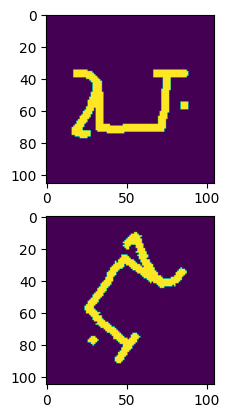

In [23]:
from torchvision import transforms
from PIL import Image

# Define the transform with random rotations
transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.ToTensor()
])

# number of augmentations of the original dataset
total_dataset = dataset
augmentations_num = 4
for _ in tqdm(range(augmentations_num)):
    augmented_dataset = AlphabetDataset(train_path, transform=transform)
    total_dataset.data.extend(augmented_dataset.data)
    total_dataset.labels.extend(augmented_dataset.labels)
    
# Plotting image and rotated augmented image 
im1 = total_dataset.data[0]
im1_aug = total_dataset.data[s]
print(im1.shape)
print(im1_aug.shape)
# Figure
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(im1.permute(1, 2, 0))
axarr[1].imshow(im1_aug.permute(1, 2, 0))

First test the model of Task 1 on the test data of task 2 to see the comparison. 

In [24]:
def evaluation_k_acc_2(model, alphabets_test_2, k):
    """
    Evaluate the model's top-k accuracy on the test alphabets.
    
    Args:
        model: The trained model to evaluate.
        alphabets_test: List of test alphabets.
        k: The number of top predictions to consider for accuracy.
    
    Returns:
        accuracy: The top-k accuracy of the model.
    """
    model.eval()
    device = 'cuda:0' if torch.cuda.is_available() and opts.cuda else 'cpu'
    print('Alphabets to test:', len(alphabets_test_2))
    
    correct = 0
    total = 0
    for alphabet_id in range(len(alphabets_test_2)):
        alphabet = alphabets_test_2[alphabet_id]
        x_A = data_dict_test_task2['annotated_images'][alphabet]  # tensor shape: (num_images, 1, height, width)
        y_A = data_dict_test_task2['annotated_images_labels'][alphabet]
        # Get unique labels
        unique_labels = list(set(y_A))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_A]
        y_A = torch.tensor(labs)
        
        x_U = data_dict_test_task2['unseen_images'][alphabet]
        y_U = data_dict_test_task2['unseen_images_labels'][alphabet]  # Convert list to tensor
        # Get unique labels
        unique_labels = list(set(y_U))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_U]
        y_U = torch.tensor(labs)

        embeddings_A = []
        with torch.no_grad():
            for image_A in x_A:
                image_A = image_A.unsqueeze(0).to(device)  # Ensure image_A has the batch dimension
                output = model(image_A)
                embeddings_A.append(output)
        embeddings_A = torch.stack(embeddings_A)

        embeddings_U = []
        with torch.no_grad():
            for image_U in x_U:
                image_U = image_U.unsqueeze(0).to(device)  # Ensure image_U has the batch dimension
                output = model(image_U)
                embeddings_U.append(output)
        embeddings_U = torch.stack(embeddings_U)

        n_classes_A = len(torch.unique(y_A))
        prototypes = []
        for c in range(n_classes_A):
            class_embeddings = embeddings_A[y_A == c]
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)
        
        for idx, embedding_U in enumerate(embeddings_U):
            distances = []
            for prototype in prototypes:
                distances.append(float(euclidean_dist(embedding_U, prototype)))
            # Get the indices of the top k smallest numbers
            top_k = list(np.argsort(distances)[:k])
            label_U = y_U[idx]
            if label_U in top_k:
                correct += 1
            total += 1
    
    accuracy = correct / total
    print(f'top-{k} accuracy:', accuracy, '\n')
    return accuracy

Evaulate.

In [25]:
alphabets_test_2 = list(data_dict_test_task2['annotated_images'].keys())

# Call the evaluation function
for k in [1, 2, 4, 8]:
    print(f'evaluating for top-{k} accuracy in the rotated dataset with task 1 model...\n')
    acc = evaluation_k_acc_2(model, alphabets_test_2, k)

evaluating for top-1 accuracy in the rotated dataset with task 1 model...

Alphabets to test: 20
top-1 accuracy: 0.11069403402284163 

evaluating for top-2 accuracy in the rotated dataset with task 1 model...

Alphabets to test: 20
top-2 accuracy: 0.17035380560658095 

evaluating for top-4 accuracy in the rotated dataset with task 1 model...

Alphabets to test: 20
top-4 accuracy: 0.26563373532465456 

evaluating for top-8 accuracy in the rotated dataset with task 1 model...

Alphabets to test: 20
top-8 accuracy: 0.40372174746426004 



Train the model of Task 1 on the augmented dataset.

In [26]:
# Define hyperparameters
from torch.utils.data import random_split
opts = {}
opts['result_path'] = 'output/model2/'
opts['epochs'] = 5
opts['learning_rate'] = 0.001
opts['lr_scheduler_step'] = 20
opts['lr_scheduler_gamma'] = 0.5
opts['iterations'] = 100
opts['classes_per_it_tr'] = 60
opts['num_support_tr'] = 4
opts['num_query_tr'] = 4
opts['classes_per_it_val'] = 50
opts['num_support_val'] = 3
opts['num_query_val'] = 3
opts['manual_seed'] = 7
opts['cuda'] = True
opts = DotDict(opts)

# Create directory for saving the results
if not os.path.exists(opts.result_path):
    os.makedirs(opts.result_path)

# Check for cuda
if torch.cuda.is_available() and not opts.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# Initialize training environment
init_seed(opts)

# Pick 100 random characters for the validation set (out of 964)
total_chars = len(np.unique(total_dataset.labels))

# Shuffle the indices of the dataset per characters
indices = np.arange(total_chars)
np.random.shuffle(indices)

# Define the sizes of the training and validation sets
num_chars_train = 864
num_chars_val = 100

# Split the indices into training and validation indices
train_indices, val_indices = indices[:num_chars_train], indices[num_chars_train:]

# Split the data and labels into training and validation sets
train_set_x = []
train_set_y = []
val_set_x = []
val_set_y = []
for i, label in enumerate(total_dataset.labels):
    if label in train_indices:
        train_set_x.append(total_dataset.data[i])
        train_set_y.append(total_dataset.labels[i])
    else:
        val_set_x.append(total_dataset.data[i])
        val_set_y.append(total_dataset.labels[i])

# Create the dataset objects for DataLoader
train_dataset = CustomDataset(train_set_x, train_set_y)
val_dataset = CustomDataset(val_set_x, val_set_y)

# dataloader
tr_dataloader = init_dataloader(opts, train_dataset, 'train')
val_dataloader = init_dataloader(opts, val_dataset, 'val')
model2 = init_protonet(opts)
optim = init_optim(opts, model2)
lr_scheduler = init_lr_scheduler(opts, optim)

# Run the training
res = train(opt=opts,
            tr_dataloader=tr_dataloader,
            val_dataloader=val_dataloader,
            model=model2,
            optim=optim,
            lr_scheduler=lr_scheduler)

# Get the training results
best_state, best_acc, train_loss, train_acc, val_loss, val_acc = res

=== Epoch: 0 ===


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Avg Train Loss: 5.661780986785889, Avg Train Acc: 0.22129166647791862
Avg Val Loss: 2.623171012401581, Avg Val Acc: 0.2845000003278255 (Best)
=== Epoch: 1 ===


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Avg Train Loss: 2.5740233421325684, Avg Train Acc: 0.31766666725277903
Avg Val Loss: 2.3203858494758607, Avg Val Acc: 0.36300000190734866 (Best)
=== Epoch: 2 ===


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Avg Train Loss: 2.2111787033081054, Avg Train Acc: 0.39683333337306975
Avg Val Loss: 1.9648236334323883, Avg Val Acc: 0.4497999981045723 (Best)
=== Epoch: 3 ===


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Avg Train Loss: 1.8090721714496611, Avg Train Acc: 0.49345833450555804
Avg Val Loss: 1.631702984571457, Avg Val Acc: 0.5529999968409538 (Best)
=== Epoch: 4 ===


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Avg Train Loss: 1.5446778464317321, Avg Train Acc: 0.5683333307504654
Avg Val Loss: 1.6919556403160094, Avg Val Acc: 0.5587999957799912 (Best)


Test the task 2 trained model on the augmented data, for the rotated test data.

In [27]:
# Call the evaluation function
for k in [1, 2, 4, 8]:
    print(f'evaluating for top-{k} accuracy in the rotated dataset with task 2 augmented model...\n')
    acc = evaluation_k_acc_2(model2, alphabets_test_2, k)

evaluating for top-1 accuracy in the rotated dataset with task 2 augmented model...

Alphabets to test: 20
top-1 accuracy: 0.25413305646513856 

evaluating for top-2 accuracy in the rotated dataset with task 2 augmented model...

Alphabets to test: 20
top-2 accuracy: 0.3761680376966696 

evaluating for top-4 accuracy in the rotated dataset with task 2 augmented model...

Alphabets to test: 20
top-4 accuracy: 0.5312674706493091 

evaluating for top-8 accuracy in the rotated dataset with task 2 augmented model...

Alphabets to test: 20
top-8 accuracy: 0.7048957750978356 



# Task 3: Domain knowledge injection

Load task 3 test data.

In [28]:
# load the test data for task 3:
import os

print('Importing test data for task 3 from file...')

test_path = 'test_data_task3.pkl'
l = 0

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    print('Importing file from GDrive')

    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Projects/Deep Learning/Assignment 1/')
    test_path = 'Data/test_data_task3.pkl'
else:
    try:
        os.chdir('/kaggle/')
        try:
            test_path = 'input/dl-assignment1-data/test_data_task3.pkl'
            data_dict_test_task3 = load_data(test_path)
            print("Running on Kaggle")
            l = 1
        except:
            test_path = 'input/dl-a1-data/test_data_task3.pkl'
            data_dict_test_task3 = load_data(test_path)
            print("Running on Kaggle")
            l = 1
    except:
        print("Not running on CoLab/Kaggle")

if l == 0:
    data_dict_test_task3 = load_data(test_path)

Importing test data for task 3 from file...
Running on Kaggle


Print the keys.

In [29]:
# the structure of the data of task 3 is exactly the same as for task 1, but now our loaded 
# dictionary contains some additional keys. These additional keys will be explained in the cells below:
print(data_dict_test_task3.keys())
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are 
# the same as for task 1, and the structure of the data is exactly the same. The key 
# 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the 
# unseen image was observed, for each alphabet. The key 'character_to_type_mapping' maps to the mapping 
# of each character to its type, for each alphabet. The key 'type_following_probs' maps to the 
# probabilities of each character type being followed by another character type, for each alphabet.

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


Print examples.

In [30]:
# examples
alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')

# a list
preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')

character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')

# a dict of dicts
type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')

Alphabet: Aurek-Besh
Some character types that preceded unseen images from the Aurek-Besh alphabet: ['II' 'II' 'II' 'I' 'II']
There are 494 preceding character types in the Aurek-Besh alphabet, and 494 unseen images.
Type of character20 from the Aurek-Besh alphabet: I
Probability of a character of type I following a character of type II in the Aurek-Besh alphabet: 0.9351351351351351


Define the usage of domain knowledge.

In [31]:
def adjust_scores_with_domain_knowledge(scores, preceding_type, type_probabilities, character_types):
    """
    Adjusts the scores based on the domain knowledge provided by the paleographer.
    
    Args:
        scores: The original scores from the model for each class.
        preceding_type: The type of the preceding character.
        type_probabilities: The probabilities P(τ(c) = X | τ(p) = Y).
        character_types: The types of characters for each class.
    
    Returns:
        Adjusted scores.
    """
    adjusted_scores = scores
    for i, score in enumerate(scores):
        if i+1 < 10:
            strc = f'character0{i+1}'
            char_type = character_types[strc]
        else:
            strc = f'character{i+1}'
            char_type = character_types[strc]
        adjustment_factor = type_probabilities[preceding_type][char_type]
        adjusted_scores[i] *= adjustment_factor
    return adjusted_scores

Evaluate the task 1 model without domain knowledge.

In [61]:
def evaluation_k_acc_3(model, alphabets_test, k):
    """
    Evaluate the model's top-k accuracy on the test alphabets.
    
    Args:
        model: The trained model to evaluate.
        alphabets_test: List of test alphabets.
        k: The number of top predictions to consider for accuracy.
    
    Returns:
        accuracy: The top-k accuracy of the model.
    """
    model.eval()
    device = 'cuda:0' if torch.cuda.is_available() and opts.cuda else 'cpu'
    print('Alphabets to test:', len(alphabets_test))
    distancer = {}
    correct = 0
    total = 0
    for alphabet_id in range(len(alphabets_test)):
        alphabet = alphabets_test[alphabet_id]
        x_A = data_dict_test_task3['annotated_images'][alphabet]  # tensor shape: (num_images, 1, height, width)
        y_A = data_dict_test_task3['annotated_images_labels'][alphabet]
        # Get unique labels
        unique_labels = list(set(y_A))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_A]
        y_A = torch.tensor(labs)
        
        x_U = data_dict_test_task3['unseen_images'][alphabet]
        y_U = data_dict_test_task3['unseen_images_labels'][alphabet]  # Convert list to tensor
        # Get unique labels
        unique_labels = list(set(y_U))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_U]
        y_U = torch.tensor(labs)

        embeddings_A = []
        with torch.no_grad():
            for image_A in x_A:
                image_A = image_A.unsqueeze(0).to(device)  # Ensure image_A has the batch dimension
                output = model(image_A)
                embeddings_A.append(output)
        embeddings_A = torch.stack(embeddings_A)

        embeddings_U = []
        with torch.no_grad():
            for image_U in x_U:
                image_U = image_U.unsqueeze(0).to(device)  # Ensure image_U has the batch dimension
                output = model(image_U)
                embeddings_U.append(output)
        embeddings_U = torch.stack(embeddings_U)

        n_classes_A = len(torch.unique(y_A))
        prototypes = []
        for c in range(n_classes_A):
            class_embeddings = embeddings_A[y_A == c]
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)
        
        for idx, embedding_U in enumerate(embeddings_U):
            distances = []
            for prototype in prototypes:
                distances.append(float(euclidean_dist(embedding_U, prototype)))
            # Get the indices of the top k smallest numbers
            top_k = list(np.argsort(distances)[:k])
            label_U = y_U[idx]
            if label_U in top_k:
                correct += 1
            total += 1
    
        scores = [-x for x in distances]
        distancer[alphabet] = scores
        
    accuracy = correct / total
    print(f'top-{k} accuracy:', accuracy, '\n')
    return accuracy, distancer


# Evaluate the random model
acc_t1 = []
for k in [1, 2, 4, 8]:
    print(f'Evaluating for top-{k} accuracy without domain knowledge...\n')
    acct, distancer = evaluation_k_acc_3(model, alphabets_test_3, k)
    acc_t1.append(acct)

Evaluating for top-1 accuracy without domain knowledge...

Alphabets to test: 20
top-1 accuracy: 0.4234486063413465 

Evaluating for top-2 accuracy without domain knowledge...

Alphabets to test: 20
top-2 accuracy: 0.569363469371456 

Evaluating for top-4 accuracy without domain knowledge...

Alphabets to test: 20
top-4 accuracy: 0.7027393978116764 

Evaluating for top-8 accuracy without domain knowledge...

Alphabets to test: 20
top-8 accuracy: 0.8285280728376327 



Plot results.

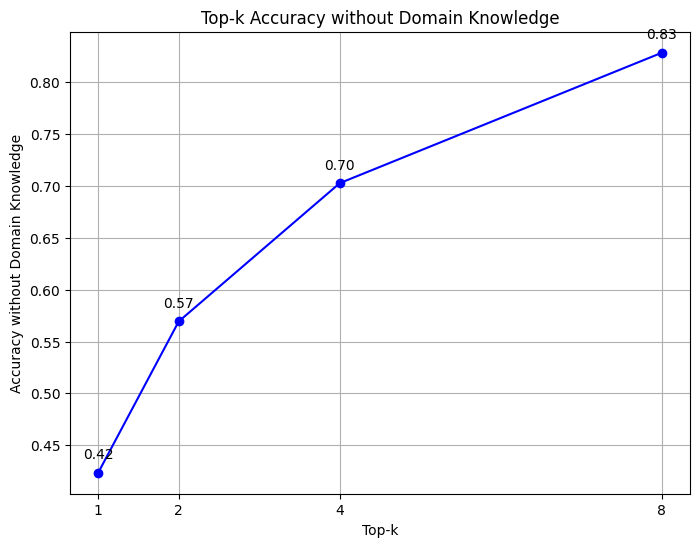

,Top-k,Accuracy without Domain Knowledge
0,1,0.423449
1,2,0.569363
2,4,0.702739
3,8,0.828528


In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
top_k = [1, 2, 4, 8]
accuracies = [acc_t1[0], acc_t1[1], acc_t1[2], acc_t1[3]]

# Create a DataFrame
data = {
    'Top-k': top_k,
    'Accuracy without Domain Knowledge': accuracies
}
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['Top-k'], df['Accuracy without Domain Knowledge'], marker='o', linestyle='-', color='b')
ax.set_xlabel('Top-k')
ax.set_ylabel('Accuracy without Domain Knowledge')
ax.set_title('Top-k Accuracy without Domain Knowledge')

# Annotate the data points
for i, txt in enumerate(accuracies):
    ax.annotate(f'{txt:.2f}', (top_k[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display the plot
plt.grid(True)
plt.xticks(top_k)
plt.show()

# Display the table
df

Define the function that will exploit the domain knowledge. 

In [57]:
def evaluation_with_domain_knowledge(model, alphabets_test_3, k):
    model.eval()
    device = 'cuda:0' if torch.cuda.is_available() and opts.cuda else 'cpu'
    correct = 0
    total = 0

    distancer = {}
    for alphabet_id in range(len(alphabets_test_3)):
        
        alphabet = alphabets_test_3[alphabet_id]
        x_A = data_dict_test_task3['annotated_images'][alphabet]
        y_A = data_dict_test_task3['annotated_images_labels'][alphabet]
        # Get unique labels
        unique_labels = list(set(y_A))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_A]
        y_A = torch.tensor(labs)
        
        x_U = data_dict_test_task3['unseen_images'][alphabet]
        y_U = data_dict_test_task3['unseen_images_labels'][alphabet]
        # Get unique labels
        unique_labels = list(set(y_U))
        # Create a mapping from label to integer
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        # Convert labels to integers
        labs = [label_to_int[label] for label in y_U]
        y_U = torch.tensor(labs)
        
        embeddings_A = []
        with torch.no_grad():
            for image_A in x_A:
                image_A = image_A.unsqueeze(0).to(device) # Ensure image_A has the batch dimension
                output = model(image_A)
                embeddings_A.append(output.cpu())
        embeddings_A = torch.stack(embeddings_A)

        embeddings_U = []
        with torch.no_grad():
            for image_U in x_U:
                image_U = image_U.unsqueeze(0).to(device) # Ensure image_U has the batch dimension
                output = model(image_U)
                embeddings_U.append(output.cpu())
        embeddings_U = torch.stack(embeddings_U)
        
        n_classes_A = len(torch.unique(y_A))
        prototypes = []
        for c in range(n_classes_A):
            class_embeddings = embeddings_A[y_A == c]
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        prototypes = torch.stack(prototypes)
        
        # Preceding character types
        preceding_types_U = data_dict_test_task3['unseen_images_preceding_types'][alphabet] 
        type_probabilities = data_dict_test_task3["type_following_probs"][alphabet]
        character_types = data_dict_test_task3["character_to_type_mapping"][alphabet]
        
        for idx, embedding_U in enumerate(embeddings_U):
            distances = []
            for prototype in prototypes:
                distances.append(float(euclidean_dist(embedding_U, prototype)))
            scores = [-x for x in distances]  # Higher score means closer (lower distance)
            preceding_type = preceding_types_U[idx]
            
            adjusted_scores = adjust_scores_with_domain_knowledge(scores, preceding_type, type_probabilities, character_types)
            
            # # Get the indices of the top k largest numbers
            top_k = list(np.argsort(adjusted_scores)[-k:][::-1])
            label_U = y_U[idx]
            if label_U in top_k:
                correct += 1
            total += 1
        
        distancer[alphabet] = adjusted_scores

    accuracy = correct / total
    print(f'top-{k} accuracy with domain knowledge:', accuracy, '\n')
    return accuracy, distancer

Evaluate the model with domain knowledge.

In [58]:
# Alphabets to test for task 3
alphabets_test_3 = list(data_dict_test_task3['annotated_images'].keys())

# Evaluate the model with domain knowledge
acc = []
for k in [1, 2, 4, 8]:
    print(f'Evaluating for top-{k} accuracy with domain knowledge...\n')
    acctt, distancert = evaluation_with_domain_knowledge(model, alphabets_test_3, k)
    acc.append(acctt)

Evaluating for top-1 accuracy with domain knowledge...

top-1 accuracy with domain knowledge: 0.27266192796102545 

Evaluating for top-2 accuracy with domain knowledge...

top-2 accuracy with domain knowledge: 0.3679418576790991 

Evaluating for top-4 accuracy with domain knowledge...

top-4 accuracy with domain knowledge: 0.4668157495407715 

Evaluating for top-8 accuracy with domain knowledge...

top-8 accuracy with domain knowledge: 0.5964379841865666 



Define random guessing baseline.

In [43]:
def random_guessing_baseline(data_dict, alphabets_test, k=1):
    correct = 0
    total = 0
    for alphabet_id in range(len(alphabets_test)):
        alphabet = alphabets_test[alphabet_id]
        # Get the true labels for unseen images
        y_U = data_dict['unseen_images_labels'][alphabet]
        y_U = np.array(y_U)
        # Get the possible labels from annotated images
        possible_labels = data_dict['annotated_images_labels'][alphabet]
        unique_labels = list(set(possible_labels))
        for label in y_U:
            # Randomly guess k labels
            guessed_labels = np.random.choice(unique_labels, k, replace=False)
            if label in guessed_labels:
                correct += 1
            total += 1
    accuracy = correct/total
    print(f'top-{k} accuracy', accuracy)
    return accuracy

Evaluate random guessing model.

In [45]:
# Evaluate the random model
acc_r = []
for k in [1, 2, 4, 8]:
    print(f'Evaluating for top-{k} accuracy with random guessing baseline...\n')
    acc_r.append(random_guessing_baseline(data_dict_test_task3, alphabets_test_3, k))

Evaluating for top-1 accuracy with random guessing baseline...

top-1 accuracy 0.031626866863669036
Evaluating for top-2 accuracy with random guessing baseline...

top-2 accuracy 0.06181614886989857
Evaluating for top-4 accuracy with random guessing baseline...

top-4 accuracy 0.12123632297739798
Evaluating for top-8 accuracy with random guessing baseline...

top-8 accuracy 0.23935787876367703


Plot figure for 13a for task3 model.

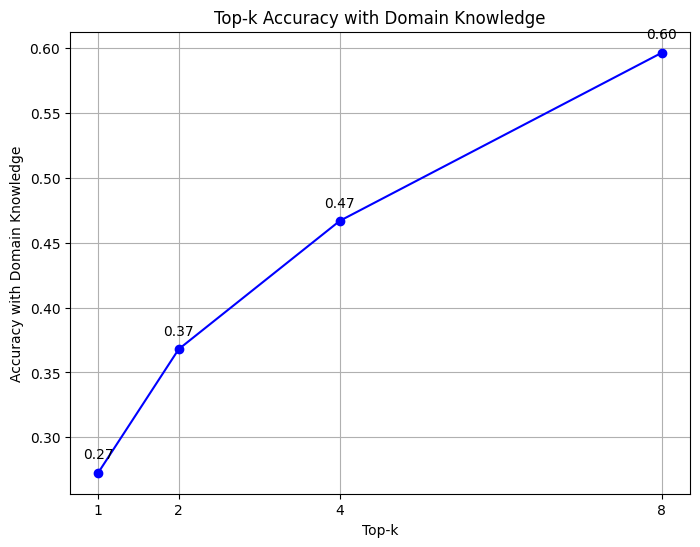

,Top-k,Accuracy with Domain Knowledge
0,1,0.272662
1,2,0.367942
2,4,0.466816
3,8,0.596438


In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
top_k = [1, 2, 4, 8]
accuracies = [acc[0], acc[1], acc[2], acc[3]]

# Create a DataFrame
data = {
    'Top-k': top_k,
    'Accuracy with Domain Knowledge': accuracies
}
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['Top-k'], df['Accuracy with Domain Knowledge'], marker='o', linestyle='-', color='b')
ax.set_xlabel('Top-k')
ax.set_ylabel('Accuracy with Domain Knowledge')
ax.set_title('Top-k Accuracy with Domain Knowledge')

# Annotate the data points
for i, txt in enumerate(accuracies):
    ax.annotate(f'{txt:.2f}', (top_k[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display the plot
plt.grid(True)
plt.xticks(top_k)
plt.show()

# Display the table
df

Plot figure for 13a for random guessing baseline.

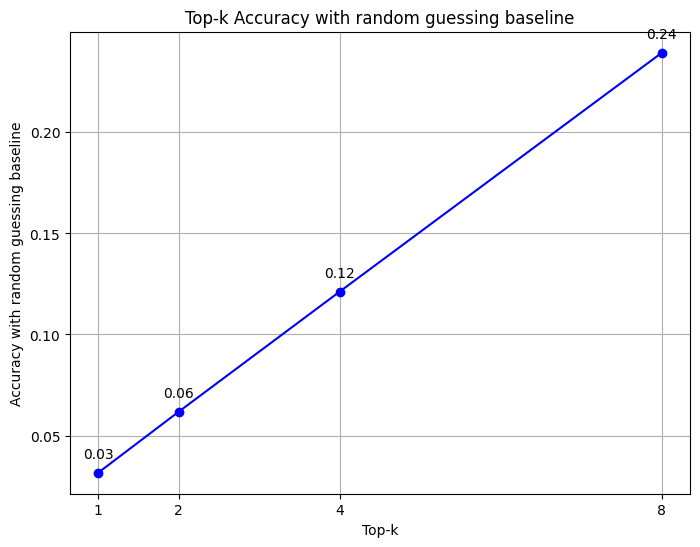

,Top-k,Accuracy with random guessing baseline
0,1,0.031627
1,2,0.061816
2,4,0.121236
3,8,0.239358


In [48]:
# Data
top_k = [1, 2, 4, 8]
accuracies = [acc_r[0], acc_r[1], acc_r[2], acc_r[3]]

# Create a DataFrame
data = {
    'Top-k': top_k,
    'Accuracy with random guessing baseline': accuracies
}
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['Top-k'], df['Accuracy with random guessing baseline'], marker='o', linestyle='-', color='b')
ax.set_xlabel('Top-k')
ax.set_ylabel('Accuracy with random guessing baseline')
ax.set_title('Top-k Accuracy with random guessing baseline')

# Annotate the data points
for i, txt in enumerate(accuracies):
    ax.annotate(f'{txt:.2f}', (top_k[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Display the plot
plt.grid(True)
plt.xticks(top_k)
plt.show()

# Display the table
df

Visualize the scores before applying domain knowledge.

In [72]:
import matplotlib.pyplot as plt

def visualize_distances(distancer):
    """
    Visualize the distances stored in the distancer dictionary.

    Args:
        distancer (dict): A dictionary where keys are alphabet strings and values are lists of distances.
    """
    num_alphabets = 3 # len(distancer)
    plt.figure(figsize=(15, num_alphabets * 5))  # Adjust the size as needed

    for idx, (alphabet, distances) in enumerate(distancer.items()):
        plt.subplot(num_alphabets, 1, idx+1)
        plt.plot(distances, marker='o')
        plt.title(f'Distances for {alphabet}')
        plt.xlabel('Index')
        plt.ylabel('Distance')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

visualize_distances(distancer)

TypeError: 'dict_items' object is not subscriptable

<Figure size 1500x1500 with 0 Axes>

Visualize the scores after applying domain knowledge.

In [ ]:
import matplotlib.pyplot as plt

def visualize_distances(distancer):
    """
    Visualize the distances stored in the distancer dictionary.

    Args:
        distancer (dict): A dictionary where keys are alphabet strings and values are lists of distances.
    """
    num_alphabets = len(distancer)
    plt.figure(figsize=(15, num_alphabets * 5))  # Adjust the size as needed

    for idx, (alphabet, distances) in enumerate(distancer.items()):
        plt.subplot(num_alphabets, 1, idx + 1)
        plt.plot(distances, marker='o')
        plt.title(f'Distances for {alphabet}')
        plt.xlabel('Index')
        plt.ylabel('Distance')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
distancer = {
    'alphabet1': [1.2, 2.3, 1.8, 2.1],
    'alphabet2': [2.0, 1.9, 2.5, 2.2],
    'alphabet3': [1.1, 1.4, 1.3, 1.5]
}

visualize_distances(distancert)